<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/v8_tomato_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d manjuphoenix/tomatodataset

100% 923M/923M [00:32<00:00, 36.8MB/s]
100% 923M/923M [00:32<00:00, 30.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.7)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 2841
The number of images in a training set is: 90912
The number of images in a validation set is: 19488
The number of images in a test set is: 5856
Dataset ImageFolder
    Number of datapoints: 64936
    Root location: /content/Tomato
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [10]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(64*32*32, 500)
        # self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(500, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        # out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = NeuralNetwork()
model = model.to(device)

In [11]:
# !pip install torch-summary
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,216
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]          12,832
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          51,264
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Linear-10                  [-1, 500]      32,768,500
           Linear-11                    [-1, 8]           4,008
Total params: 32,837,820
Trainable params: 32,837,820
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Fo

In [12]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=8, bias=True)
)

In [13]:
class EarlyStopping():
  """ Early stopping is used to stop the training process to avoid overfitting of the model when the loss does not improve after certain epochs"""
  def __init__(self, patience=6, min_delta=0):
      """
      Parameters:
      Patience: Number of epochs to wait before stopping when the loss is not improving
      min_delta: Minimum difference between new loss and the old loss for new loss to be considered as an improvement
      """
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.best_loss = None
      self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print("INFO: Early Stopping")
        self.early_stop = True

In [14]:
from tqdm import tqdm

def train(model,loss_fn,dataloader,optimizer,epoch):
    print('\nEpoch : %d'%epoch)
    total_loss=0    
    correct=0
    total=0

    model.train()
    for data in tqdm(dataloader):
        inputs,labels=data[0].to(device),data[1].to(device)
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    loss=total_loss/len(dataloader)
    accuracy=100.*correct/total
    
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.4f | Accuracy: %.4f'%(loss,accuracy))
    return loss, accuracy

In [15]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()
    total_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= loss_fn(outputs,labels)
            total_loss+=loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        loss=total_loss/len(dataloader)
        accuracy=100.*correct/total
        losses['val'].append(loss)
        accuracies['val'].append(accuracy)
        print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 
    return loss, accuracy

In [16]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.00001

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6)

In [17]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=400
early_stopping = EarlyStopping()
for epoch in range(1,epochs+1): 
  train_loss, train_accuracy = train(model,loss_fn,train_loader,optimizer_ft,epoch)
  val_loss, val_accuracy = test(model,loss_fn,val_loader,epoch)
  early_stopping(val_loss)
  if early_stopping.early_stop:
    break


Epoch : 1


100%|██████████| 2841/2841 [04:21<00:00, 10.86it/s]


Train Loss: 2.0789 | Accuracy: 12.4497


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 2.078 | Accuracy: 12.268

Epoch : 2


100%|██████████| 2841/2841 [04:21<00:00, 10.85it/s]


Train Loss: 2.0773 | Accuracy: 14.9500


100%|██████████| 609/609 [00:52<00:00, 11.66it/s]


Test Loss: 2.077 | Accuracy: 15.636

Epoch : 3


100%|██████████| 2841/2841 [04:19<00:00, 10.93it/s]


Train Loss: 2.0759 | Accuracy: 14.5628


100%|██████████| 609/609 [00:53<00:00, 11.45it/s]


Test Loss: 2.076 | Accuracy: 13.403

Epoch : 4


100%|██████████| 2841/2841 [04:17<00:00, 11.03it/s]


Train Loss: 2.0750 | Accuracy: 13.3264


100%|██████████| 609/609 [00:52<00:00, 11.59it/s]


Test Loss: 2.075 | Accuracy: 13.259

Epoch : 5


100%|██████████| 2841/2841 [04:18<00:00, 11.01it/s]


Train Loss: 2.0738 | Accuracy: 14.0469


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 2.074 | Accuracy: 13.577

Epoch : 6


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 2.0730 | Accuracy: 14.3714


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 2.073 | Accuracy: 15.230

Epoch : 7


100%|██████████| 2841/2841 [04:22<00:00, 10.84it/s]


Train Loss: 2.0720 | Accuracy: 14.6178


100%|██████████| 609/609 [00:53<00:00, 11.43it/s]


Test Loss: 2.072 | Accuracy: 12.884

Epoch : 8


100%|██████████| 2841/2841 [04:22<00:00, 10.84it/s]


Train Loss: 2.0710 | Accuracy: 13.5090


100%|██████████| 609/609 [00:53<00:00, 11.44it/s]


Test Loss: 2.071 | Accuracy: 14.594

Epoch : 9


100%|██████████| 2841/2841 [04:22<00:00, 10.80it/s]


Train Loss: 2.0698 | Accuracy: 16.3282


100%|██████████| 609/609 [00:52<00:00, 11.66it/s]


Test Loss: 2.070 | Accuracy: 16.857

Epoch : 10


100%|██████████| 2841/2841 [04:21<00:00, 10.86it/s]


Train Loss: 2.0683 | Accuracy: 15.3899


100%|██████████| 609/609 [00:53<00:00, 11.43it/s]


Test Loss: 2.068 | Accuracy: 14.979

Epoch : 11


100%|██████████| 2841/2841 [04:19<00:00, 10.94it/s]


Train Loss: 2.0669 | Accuracy: 17.2643


100%|██████████| 609/609 [00:53<00:00, 11.35it/s]


Test Loss: 2.067 | Accuracy: 17.679

Epoch : 12


100%|██████████| 2841/2841 [04:20<00:00, 10.92it/s]


Train Loss: 2.0655 | Accuracy: 17.2192


100%|██████████| 609/609 [00:51<00:00, 11.87it/s]


Test Loss: 2.065 | Accuracy: 16.822

Epoch : 13


100%|██████████| 2841/2841 [04:16<00:00, 11.08it/s]


Train Loss: 2.0633 | Accuracy: 16.1214


100%|██████████| 609/609 [00:51<00:00, 11.77it/s]


Test Loss: 2.063 | Accuracy: 16.036

Epoch : 14


100%|██████████| 2841/2841 [04:14<00:00, 11.18it/s]


Train Loss: 2.0610 | Accuracy: 17.1554


100%|██████████| 609/609 [00:52<00:00, 11.63it/s]


Test Loss: 2.060 | Accuracy: 17.135

Epoch : 15


100%|██████████| 2841/2841 [04:15<00:00, 11.14it/s]


Train Loss: 2.0584 | Accuracy: 17.1873


100%|██████████| 609/609 [00:51<00:00, 11.79it/s]


Test Loss: 2.058 | Accuracy: 17.920

Epoch : 16


100%|██████████| 2841/2841 [04:14<00:00, 11.15it/s]


Train Loss: 2.0554 | Accuracy: 18.2092


100%|██████████| 609/609 [00:51<00:00, 11.85it/s]


Test Loss: 2.054 | Accuracy: 17.828

Epoch : 17


100%|██████████| 2841/2841 [04:13<00:00, 11.21it/s]


Train Loss: 2.0519 | Accuracy: 18.6899


100%|██████████| 609/609 [00:51<00:00, 11.89it/s]


Test Loss: 2.050 | Accuracy: 19.747

Epoch : 18


100%|██████████| 2841/2841 [04:13<00:00, 11.21it/s]


Train Loss: 2.0465 | Accuracy: 20.6446


100%|██████████| 609/609 [00:51<00:00, 11.73it/s]


Test Loss: 2.045 | Accuracy: 20.025

Epoch : 19


100%|██████████| 2841/2841 [04:14<00:00, 11.17it/s]


Train Loss: 2.0403 | Accuracy: 21.2034


100%|██████████| 609/609 [00:51<00:00, 11.88it/s]


Test Loss: 2.037 | Accuracy: 22.227

Epoch : 20


100%|██████████| 2841/2841 [04:13<00:00, 11.22it/s]


Train Loss: 2.0324 | Accuracy: 24.5859


100%|██████████| 609/609 [00:50<00:00, 11.96it/s]


Test Loss: 2.028 | Accuracy: 25.989

Epoch : 21


100%|██████████| 2841/2841 [04:14<00:00, 11.15it/s]


Train Loss: 2.0215 | Accuracy: 27.0817


100%|██████████| 609/609 [00:51<00:00, 11.79it/s]


Test Loss: 2.014 | Accuracy: 27.848

Epoch : 22


100%|██████████| 2841/2841 [04:13<00:00, 11.20it/s]


Train Loss: 2.0063 | Accuracy: 27.6240


100%|██████████| 609/609 [00:51<00:00, 11.76it/s]


Test Loss: 1.998 | Accuracy: 27.940

Epoch : 23


100%|██████████| 2841/2841 [04:15<00:00, 11.14it/s]


Train Loss: 1.9859 | Accuracy: 28.0442


100%|██████████| 609/609 [00:51<00:00, 11.91it/s]


Test Loss: 1.974 | Accuracy: 28.371

Epoch : 24


100%|██████████| 2841/2841 [04:14<00:00, 11.16it/s]


Train Loss: 1.9612 | Accuracy: 28.3984


100%|██████████| 609/609 [00:52<00:00, 11.65it/s]


Test Loss: 1.947 | Accuracy: 28.956

Epoch : 25


100%|██████████| 2841/2841 [04:14<00:00, 11.16it/s]


Train Loss: 1.9350 | Accuracy: 28.3841


100%|██████████| 609/609 [00:51<00:00, 11.93it/s]


Test Loss: 1.920 | Accuracy: 29.013

Epoch : 26


100%|██████████| 2841/2841 [04:17<00:00, 11.05it/s]


Train Loss: 1.9080 | Accuracy: 28.8802


100%|██████████| 609/609 [00:52<00:00, 11.59it/s]


Test Loss: 1.893 | Accuracy: 29.434

Epoch : 27


100%|██████████| 2841/2841 [04:17<00:00, 11.04it/s]


Train Loss: 1.8891 | Accuracy: 29.5347


100%|██████████| 609/609 [00:51<00:00, 11.82it/s]


Test Loss: 1.874 | Accuracy: 30.250

Epoch : 28


100%|██████████| 2841/2841 [04:17<00:00, 11.04it/s]


Train Loss: 1.8692 | Accuracy: 30.4763


100%|██████████| 609/609 [00:53<00:00, 11.49it/s]


Test Loss: 1.861 | Accuracy: 31.487

Epoch : 29


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 1.8582 | Accuracy: 31.0263


100%|██████████| 609/609 [00:51<00:00, 11.76it/s]


Test Loss: 1.847 | Accuracy: 32.021

Epoch : 30


100%|██████████| 2841/2841 [04:17<00:00, 11.03it/s]


Train Loss: 1.8464 | Accuracy: 31.5081


100%|██████████| 609/609 [00:52<00:00, 11.56it/s]


Test Loss: 1.838 | Accuracy: 32.262

Epoch : 31


100%|██████████| 2841/2841 [04:16<00:00, 11.08it/s]


Train Loss: 1.8380 | Accuracy: 31.9470


100%|██████████| 609/609 [00:51<00:00, 11.79it/s]


Test Loss: 1.826 | Accuracy: 33.161

Epoch : 32


100%|██████████| 2841/2841 [04:16<00:00, 11.06it/s]


Train Loss: 1.8259 | Accuracy: 32.6125


100%|██████████| 609/609 [00:51<00:00, 11.80it/s]


Test Loss: 1.817 | Accuracy: 33.895

Epoch : 33


100%|██████████| 2841/2841 [04:12<00:00, 11.24it/s]


Train Loss: 1.8167 | Accuracy: 33.2571


100%|██████████| 609/609 [00:50<00:00, 12.05it/s]


Test Loss: 1.808 | Accuracy: 34.423

Epoch : 34


100%|██████████| 2841/2841 [04:11<00:00, 11.32it/s]


Train Loss: 1.8043 | Accuracy: 34.1558


100%|██████████| 609/609 [00:51<00:00, 11.92it/s]


Test Loss: 1.795 | Accuracy: 35.239

Epoch : 35


100%|██████████| 2841/2841 [04:10<00:00, 11.32it/s]


Train Loss: 1.7971 | Accuracy: 34.3395


100%|██████████| 609/609 [00:51<00:00, 11.87it/s]


Test Loss: 1.788 | Accuracy: 34.901

Epoch : 36


100%|██████████| 2841/2841 [04:12<00:00, 11.25it/s]


Train Loss: 1.7862 | Accuracy: 35.0786


100%|██████████| 609/609 [00:52<00:00, 11.69it/s]


Test Loss: 1.782 | Accuracy: 34.819

Epoch : 37


100%|██████████| 2841/2841 [04:18<00:00, 10.98it/s]


Train Loss: 1.7755 | Accuracy: 35.4218


100%|██████████| 609/609 [00:54<00:00, 11.15it/s]


Test Loss: 1.769 | Accuracy: 35.943

Epoch : 38


100%|██████████| 2841/2841 [04:38<00:00, 10.22it/s]


Train Loss: 1.7719 | Accuracy: 35.9729


100%|██████████| 609/609 [00:52<00:00, 11.61it/s]


Test Loss: 1.764 | Accuracy: 37.282

Epoch : 39


100%|██████████| 2841/2841 [04:19<00:00, 10.93it/s]


Train Loss: 1.7606 | Accuracy: 36.8661


100%|██████████| 609/609 [00:52<00:00, 11.52it/s]


Test Loss: 1.748 | Accuracy: 37.128

Epoch : 40


100%|██████████| 2841/2841 [04:21<00:00, 10.85it/s]


Train Loss: 1.7542 | Accuracy: 37.0718


100%|██████████| 609/609 [00:52<00:00, 11.64it/s]


Test Loss: 1.742 | Accuracy: 37.919

Epoch : 41


100%|██████████| 2841/2841 [04:21<00:00, 10.87it/s]


Train Loss: 1.7404 | Accuracy: 37.7791


100%|██████████| 609/609 [00:54<00:00, 11.23it/s]


Test Loss: 1.736 | Accuracy: 38.345

Epoch : 42


100%|██████████| 2841/2841 [04:23<00:00, 10.78it/s]


Train Loss: 1.7296 | Accuracy: 38.2125


100%|██████████| 609/609 [00:53<00:00, 11.44it/s]


Test Loss: 1.727 | Accuracy: 38.899

Epoch : 43


100%|██████████| 2841/2841 [04:24<00:00, 10.74it/s]


Train Loss: 1.7189 | Accuracy: 38.7460


100%|██████████| 609/609 [00:53<00:00, 11.29it/s]


Test Loss: 1.707 | Accuracy: 39.567

Epoch : 44


100%|██████████| 2841/2841 [04:23<00:00, 10.76it/s]


Train Loss: 1.7037 | Accuracy: 39.6711


100%|██████████| 609/609 [00:53<00:00, 11.43it/s]


Test Loss: 1.697 | Accuracy: 40.316

Epoch : 45


100%|██████████| 2841/2841 [04:15<00:00, 11.12it/s]


Train Loss: 1.6916 | Accuracy: 40.2750


100%|██████████| 609/609 [00:50<00:00, 11.95it/s]


Test Loss: 1.683 | Accuracy: 40.701

Epoch : 46


100%|██████████| 2841/2841 [04:20<00:00, 10.89it/s]


Train Loss: 1.6822 | Accuracy: 40.7920


100%|██████████| 609/609 [00:54<00:00, 11.18it/s]


Test Loss: 1.675 | Accuracy: 41.882

Epoch : 47


100%|██████████| 2841/2841 [04:22<00:00, 10.81it/s]


Train Loss: 1.6653 | Accuracy: 41.7853


100%|██████████| 609/609 [00:51<00:00, 11.71it/s]


Test Loss: 1.650 | Accuracy: 42.985

Epoch : 48


100%|██████████| 2841/2841 [04:21<00:00, 10.87it/s]


Train Loss: 1.6529 | Accuracy: 42.5982


100%|██████████| 609/609 [00:52<00:00, 11.67it/s]


Test Loss: 1.645 | Accuracy: 43.406

Epoch : 49


100%|██████████| 2841/2841 [04:19<00:00, 10.95it/s]


Train Loss: 1.6380 | Accuracy: 43.0789


100%|██████████| 609/609 [00:53<00:00, 11.45it/s]


Test Loss: 1.613 | Accuracy: 44.105

Epoch : 50


100%|██████████| 2841/2841 [04:18<00:00, 10.97it/s]


Train Loss: 1.6177 | Accuracy: 44.0535


100%|██████████| 609/609 [00:51<00:00, 11.77it/s]


Test Loss: 1.611 | Accuracy: 45.336

Epoch : 51


100%|██████████| 2841/2841 [04:18<00:00, 11.00it/s]


Train Loss: 1.6000 | Accuracy: 44.7520


100%|██████████| 609/609 [00:53<00:00, 11.44it/s]


Test Loss: 1.589 | Accuracy: 45.111

Epoch : 52


100%|██████████| 2841/2841 [04:16<00:00, 11.06it/s]


Train Loss: 1.5843 | Accuracy: 45.3591


100%|██████████| 609/609 [00:51<00:00, 11.75it/s]


Test Loss: 1.574 | Accuracy: 45.588

Epoch : 53


100%|██████████| 2841/2841 [04:15<00:00, 11.12it/s]


Train Loss: 1.5676 | Accuracy: 45.9058


100%|██████████| 609/609 [00:51<00:00, 11.78it/s]


Test Loss: 1.561 | Accuracy: 45.706

Epoch : 54


100%|██████████| 2841/2841 [04:15<00:00, 11.13it/s]


Train Loss: 1.5525 | Accuracy: 46.5130


100%|██████████| 609/609 [00:52<00:00, 11.59it/s]


Test Loss: 1.547 | Accuracy: 46.635

Epoch : 55


100%|██████████| 2841/2841 [04:17<00:00, 11.01it/s]


Train Loss: 1.5371 | Accuracy: 47.3380


100%|██████████| 609/609 [00:51<00:00, 11.86it/s]


Test Loss: 1.531 | Accuracy: 47.528

Epoch : 56


100%|██████████| 2841/2841 [04:19<00:00, 10.93it/s]


Train Loss: 1.5234 | Accuracy: 47.8264


100%|██████████| 609/609 [00:52<00:00, 11.49it/s]


Test Loss: 1.521 | Accuracy: 48.175

Epoch : 57


100%|██████████| 2841/2841 [04:22<00:00, 10.84it/s]


Train Loss: 1.5143 | Accuracy: 48.2158


100%|██████████| 609/609 [00:53<00:00, 11.39it/s]


Test Loss: 1.507 | Accuracy: 47.831

Epoch : 58


100%|██████████| 2841/2841 [04:24<00:00, 10.72it/s]


Train Loss: 1.4950 | Accuracy: 48.8406


100%|██████████| 609/609 [00:53<00:00, 11.34it/s]


Test Loss: 1.488 | Accuracy: 49.741

Epoch : 59


100%|██████████| 2841/2841 [04:19<00:00, 10.96it/s]


Train Loss: 1.4835 | Accuracy: 49.2256


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 1.469 | Accuracy: 49.161

Epoch : 60


100%|██████████| 2841/2841 [04:20<00:00, 10.92it/s]


Train Loss: 1.4660 | Accuracy: 49.4841


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 1.465 | Accuracy: 48.796

Epoch : 61


100%|██████████| 2841/2841 [04:18<00:00, 11.00it/s]


Train Loss: 1.4462 | Accuracy: 50.0473


100%|██████████| 609/609 [00:52<00:00, 11.66it/s]


Test Loss: 1.455 | Accuracy: 51.086

Epoch : 62


100%|██████████| 2841/2841 [04:14<00:00, 11.16it/s]


Train Loss: 1.4341 | Accuracy: 50.5995


100%|██████████| 609/609 [00:52<00:00, 11.63it/s]


Test Loss: 1.420 | Accuracy: 51.296

Epoch : 63


100%|██████████| 2841/2841 [04:18<00:00, 11.00it/s]


Train Loss: 1.4272 | Accuracy: 50.6798


100%|██████████| 609/609 [00:51<00:00, 11.72it/s]


Test Loss: 1.413 | Accuracy: 50.998

Epoch : 64


100%|██████████| 2841/2841 [04:20<00:00, 10.91it/s]


Train Loss: 1.4068 | Accuracy: 51.3222


100%|██████████| 609/609 [00:53<00:00, 11.39it/s]


Test Loss: 1.398 | Accuracy: 51.050

Epoch : 65


100%|██████████| 2841/2841 [04:21<00:00, 10.84it/s]


Train Loss: 1.3950 | Accuracy: 51.5323


100%|██████████| 609/609 [00:52<00:00, 11.50it/s]


Test Loss: 1.387 | Accuracy: 52.179

Epoch : 66


100%|██████████| 2841/2841 [04:19<00:00, 10.94it/s]


Train Loss: 1.3773 | Accuracy: 52.2561


100%|██████████| 609/609 [00:53<00:00, 11.49it/s]


Test Loss: 1.374 | Accuracy: 52.410

Epoch : 67


100%|██████████| 2841/2841 [04:22<00:00, 10.82it/s]


Train Loss: 1.3607 | Accuracy: 52.8798


100%|██████████| 609/609 [00:52<00:00, 11.56it/s]


Test Loss: 1.368 | Accuracy: 51.188

Epoch : 68


100%|██████████| 2841/2841 [04:21<00:00, 10.85it/s]


Train Loss: 1.3536 | Accuracy: 53.0459


100%|██████████| 609/609 [00:53<00:00, 11.31it/s]


Test Loss: 1.354 | Accuracy: 52.456

Epoch : 69


100%|██████████| 2841/2841 [04:21<00:00, 10.87it/s]


Train Loss: 1.3420 | Accuracy: 53.2318


100%|██████████| 609/609 [00:53<00:00, 11.37it/s]


Test Loss: 1.341 | Accuracy: 53.663

Epoch : 70


100%|██████████| 2841/2841 [04:24<00:00, 10.74it/s]


Train Loss: 1.3352 | Accuracy: 53.7631


100%|██████████| 609/609 [00:53<00:00, 11.48it/s]


Test Loss: 1.326 | Accuracy: 53.390

Epoch : 71


100%|██████████| 2841/2841 [04:19<00:00, 10.94it/s]


Train Loss: 1.3170 | Accuracy: 54.1052


100%|██████████| 609/609 [00:53<00:00, 11.38it/s]


Test Loss: 1.309 | Accuracy: 54.515

Epoch : 72


100%|██████████| 2841/2841 [04:16<00:00, 11.07it/s]


Train Loss: 1.2978 | Accuracy: 54.8400


100%|██████████| 609/609 [00:51<00:00, 11.81it/s]


Test Loss: 1.296 | Accuracy: 54.977

Epoch : 73


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 1.2973 | Accuracy: 54.6805


100%|██████████| 609/609 [00:52<00:00, 11.63it/s]


Test Loss: 1.287 | Accuracy: 54.402

Epoch : 74


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 1.2831 | Accuracy: 55.2194


100%|██████████| 609/609 [00:52<00:00, 11.52it/s]


Test Loss: 1.281 | Accuracy: 54.746

Epoch : 75


100%|██████████| 2841/2841 [04:19<00:00, 10.96it/s]


Train Loss: 1.2704 | Accuracy: 55.3679


100%|██████████| 609/609 [00:52<00:00, 11.56it/s]


Test Loss: 1.270 | Accuracy: 55.911

Epoch : 76


100%|██████████| 2841/2841 [04:17<00:00, 11.05it/s]


Train Loss: 1.2588 | Accuracy: 55.9432


100%|██████████| 609/609 [00:52<00:00, 11.56it/s]


Test Loss: 1.248 | Accuracy: 56.111

Epoch : 77


100%|██████████| 2841/2841 [04:16<00:00, 11.06it/s]


Train Loss: 1.2502 | Accuracy: 55.8123


100%|██████████| 609/609 [00:51<00:00, 11.76it/s]


Test Loss: 1.235 | Accuracy: 55.854

Epoch : 78


100%|██████████| 2841/2841 [04:16<00:00, 11.06it/s]


Train Loss: 1.2377 | Accuracy: 56.6637


100%|██████████| 609/609 [00:52<00:00, 11.69it/s]


Test Loss: 1.228 | Accuracy: 56.301

Epoch : 79


100%|██████████| 2841/2841 [04:15<00:00, 11.10it/s]


Train Loss: 1.2349 | Accuracy: 56.3491


100%|██████████| 609/609 [00:51<00:00, 11.86it/s]


Test Loss: 1.221 | Accuracy: 57.620

Epoch : 80


100%|██████████| 2841/2841 [04:12<00:00, 11.24it/s]


Train Loss: 1.2154 | Accuracy: 57.1972


100%|██████████| 609/609 [00:50<00:00, 12.02it/s]


Test Loss: 1.210 | Accuracy: 57.348

Epoch : 81


100%|██████████| 2841/2841 [04:14<00:00, 11.17it/s]


Train Loss: 1.2108 | Accuracy: 57.2742


100%|██████████| 609/609 [00:51<00:00, 11.75it/s]


Test Loss: 1.205 | Accuracy: 57.646

Epoch : 82


100%|██████████| 2841/2841 [04:13<00:00, 11.21it/s]


Train Loss: 1.2026 | Accuracy: 57.4139


100%|██████████| 609/609 [00:51<00:00, 11.87it/s]


Test Loss: 1.195 | Accuracy: 57.405

Epoch : 83


100%|██████████| 2841/2841 [04:13<00:00, 11.23it/s]


Train Loss: 1.1932 | Accuracy: 57.7307


100%|██████████| 609/609 [00:51<00:00, 11.81it/s]


Test Loss: 1.194 | Accuracy: 56.476

Epoch : 84


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 1.1904 | Accuracy: 57.8440


100%|██████████| 609/609 [00:51<00:00, 11.92it/s]


Test Loss: 1.186 | Accuracy: 57.990

Epoch : 85


100%|██████████| 2841/2841 [04:13<00:00, 11.20it/s]


Train Loss: 1.1736 | Accuracy: 58.3214


100%|██████████| 609/609 [00:51<00:00, 11.82it/s]


Test Loss: 1.173 | Accuracy: 58.693

Epoch : 86


100%|██████████| 2841/2841 [04:15<00:00, 11.13it/s]


Train Loss: 1.1746 | Accuracy: 58.2576


100%|██████████| 609/609 [00:51<00:00, 11.72it/s]


Test Loss: 1.176 | Accuracy: 57.240
INFO: Early stopping counter 1 of 6

Epoch : 87


100%|██████████| 2841/2841 [04:18<00:00, 10.98it/s]


Train Loss: 1.1669 | Accuracy: 58.4930


100%|██████████| 609/609 [00:52<00:00, 11.55it/s]


Test Loss: 1.175 | Accuracy: 58.652
INFO: Early stopping counter 2 of 6

Epoch : 88


100%|██████████| 2841/2841 [04:18<00:00, 10.97it/s]


Train Loss: 1.1547 | Accuracy: 59.0254


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 1.156 | Accuracy: 58.349

Epoch : 89


100%|██████████| 2841/2841 [04:18<00:00, 10.99it/s]


Train Loss: 1.1527 | Accuracy: 58.9242


100%|██████████| 609/609 [00:52<00:00, 11.66it/s]


Test Loss: 1.159 | Accuracy: 59.586
INFO: Early stopping counter 1 of 6

Epoch : 90


100%|██████████| 2841/2841 [04:18<00:00, 10.97it/s]


Train Loss: 1.1504 | Accuracy: 59.0287


100%|██████████| 609/609 [00:52<00:00, 11.51it/s]


Test Loss: 1.154 | Accuracy: 58.934

Epoch : 91


100%|██████████| 2841/2841 [04:20<00:00, 10.91it/s]


Train Loss: 1.1424 | Accuracy: 59.1233


100%|██████████| 609/609 [00:52<00:00, 11.64it/s]


Test Loss: 1.153 | Accuracy: 59.242

Epoch : 92


100%|██████████| 2841/2841 [04:20<00:00, 10.92it/s]


Train Loss: 1.1375 | Accuracy: 59.4082


100%|██████████| 609/609 [00:52<00:00, 11.50it/s]


Test Loss: 1.127 | Accuracy: 59.360

Epoch : 93


100%|██████████| 2841/2841 [04:18<00:00, 11.01it/s]


Train Loss: 1.1354 | Accuracy: 59.5061


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 1.127 | Accuracy: 59.253
INFO: Early stopping counter 1 of 6

Epoch : 94


100%|██████████| 2841/2841 [04:19<00:00, 10.93it/s]


Train Loss: 1.1259 | Accuracy: 59.8977


100%|██████████| 609/609 [00:52<00:00, 11.55it/s]


Test Loss: 1.134 | Accuracy: 59.725
INFO: Early stopping counter 2 of 6

Epoch : 95


100%|██████████| 2841/2841 [04:19<00:00, 10.93it/s]


Train Loss: 1.1148 | Accuracy: 60.1518


100%|██████████| 609/609 [00:52<00:00, 11.52it/s]


Test Loss: 1.113 | Accuracy: 59.638

Epoch : 96


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 1.1147 | Accuracy: 60.2849


100%|██████████| 609/609 [00:52<00:00, 11.65it/s]


Test Loss: 1.124 | Accuracy: 59.217
INFO: Early stopping counter 1 of 6

Epoch : 97


100%|██████████| 2841/2841 [04:17<00:00, 11.03it/s]


Train Loss: 1.1079 | Accuracy: 60.4378


100%|██████████| 609/609 [00:52<00:00, 11.55it/s]


Test Loss: 1.108 | Accuracy: 60.228

Epoch : 98


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 1.1028 | Accuracy: 60.6072


100%|██████████| 609/609 [00:52<00:00, 11.65it/s]


Test Loss: 1.100 | Accuracy: 60.464

Epoch : 99


100%|██████████| 2841/2841 [04:18<00:00, 10.98it/s]


Train Loss: 1.0990 | Accuracy: 60.8503


100%|██████████| 609/609 [00:51<00:00, 11.73it/s]


Test Loss: 1.101 | Accuracy: 60.290
INFO: Early stopping counter 1 of 6

Epoch : 100


100%|██████████| 2841/2841 [04:18<00:00, 11.00it/s]


Train Loss: 1.0991 | Accuracy: 60.5577


100%|██████████| 609/609 [00:52<00:00, 11.64it/s]


Test Loss: 1.091 | Accuracy: 61.229

Epoch : 101


100%|██████████| 2841/2841 [04:15<00:00, 11.11it/s]


Train Loss: 1.0939 | Accuracy: 60.9691


100%|██████████| 609/609 [00:51<00:00, 11.80it/s]


Test Loss: 1.093 | Accuracy: 60.562
INFO: Early stopping counter 1 of 6

Epoch : 102


100%|██████████| 2841/2841 [04:15<00:00, 11.11it/s]


Train Loss: 1.0834 | Accuracy: 61.3189


100%|██████████| 609/609 [00:51<00:00, 11.81it/s]


Test Loss: 1.090 | Accuracy: 61.465

Epoch : 103


100%|██████████| 2841/2841 [04:14<00:00, 11.18it/s]


Train Loss: 1.0842 | Accuracy: 61.2551


100%|██████████| 609/609 [00:51<00:00, 11.86it/s]


Test Loss: 1.079 | Accuracy: 61.244

Epoch : 104


100%|██████████| 2841/2841 [04:14<00:00, 11.15it/s]


Train Loss: 1.0786 | Accuracy: 61.3959


100%|██████████| 609/609 [00:51<00:00, 11.78it/s]


Test Loss: 1.092 | Accuracy: 60.675
INFO: Early stopping counter 1 of 6

Epoch : 105


100%|██████████| 2841/2841 [04:14<00:00, 11.16it/s]


Train Loss: 1.0715 | Accuracy: 61.5884


100%|██████████| 609/609 [00:51<00:00, 11.91it/s]


Test Loss: 1.087 | Accuracy: 61.552
INFO: Early stopping counter 2 of 6

Epoch : 106


100%|██████████| 2841/2841 [04:13<00:00, 11.19it/s]


Train Loss: 1.0688 | Accuracy: 61.7974


100%|██████████| 609/609 [00:51<00:00, 11.83it/s]


Test Loss: 1.064 | Accuracy: 61.722

Epoch : 107


100%|██████████| 2841/2841 [04:13<00:00, 11.19it/s]


Train Loss: 1.0594 | Accuracy: 62.2517


100%|██████████| 609/609 [00:50<00:00, 11.97it/s]


Test Loss: 1.078 | Accuracy: 61.901
INFO: Early stopping counter 1 of 6

Epoch : 108


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 1.0627 | Accuracy: 62.1747


100%|██████████| 609/609 [00:52<00:00, 11.65it/s]


Test Loss: 1.060 | Accuracy: 61.896

Epoch : 109


100%|██████████| 2841/2841 [04:16<00:00, 11.08it/s]


Train Loss: 1.0542 | Accuracy: 62.6477


100%|██████████| 609/609 [00:52<00:00, 11.64it/s]


Test Loss: 1.051 | Accuracy: 61.932

Epoch : 110


100%|██████████| 2841/2841 [04:16<00:00, 11.06it/s]


Train Loss: 1.0587 | Accuracy: 62.1373


100%|██████████| 609/609 [00:52<00:00, 11.69it/s]


Test Loss: 1.055 | Accuracy: 62.584
INFO: Early stopping counter 1 of 6

Epoch : 111


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 1.0500 | Accuracy: 62.6774


100%|██████████| 609/609 [00:52<00:00, 11.69it/s]


Test Loss: 1.045 | Accuracy: 62.148

Epoch : 112


100%|██████████| 2841/2841 [04:15<00:00, 11.11it/s]


Train Loss: 1.0463 | Accuracy: 62.4992


100%|██████████| 609/609 [00:52<00:00, 11.68it/s]


Test Loss: 1.064 | Accuracy: 62.522
INFO: Early stopping counter 1 of 6

Epoch : 113


100%|██████████| 2841/2841 [04:16<00:00, 11.07it/s]


Train Loss: 1.0426 | Accuracy: 62.8952


100%|██████████| 609/609 [00:52<00:00, 11.64it/s]


Test Loss: 1.054 | Accuracy: 62.071
INFO: Early stopping counter 2 of 6

Epoch : 114


100%|██████████| 2841/2841 [04:16<00:00, 11.08it/s]


Train Loss: 1.0356 | Accuracy: 63.0206


100%|██████████| 609/609 [00:51<00:00, 11.84it/s]


Test Loss: 1.050 | Accuracy: 61.901
INFO: Early stopping counter 3 of 6

Epoch : 115


100%|██████████| 2841/2841 [04:18<00:00, 10.97it/s]


Train Loss: 1.0336 | Accuracy: 63.0899


100%|██████████| 609/609 [00:51<00:00, 11.79it/s]


Test Loss: 1.046 | Accuracy: 61.973
INFO: Early stopping counter 4 of 6

Epoch : 116


100%|██████████| 2841/2841 [04:16<00:00, 11.07it/s]


Train Loss: 1.0325 | Accuracy: 63.1955


100%|██████████| 609/609 [00:52<00:00, 11.67it/s]


Test Loss: 1.041 | Accuracy: 63.457

Epoch : 117


100%|██████████| 2841/2841 [04:17<00:00, 11.04it/s]


Train Loss: 1.0283 | Accuracy: 63.3055


100%|██████████| 609/609 [00:52<00:00, 11.54it/s]


Test Loss: 1.059 | Accuracy: 61.588
INFO: Early stopping counter 1 of 6

Epoch : 118


100%|██████████| 2841/2841 [04:22<00:00, 10.81it/s]


Train Loss: 1.0264 | Accuracy: 63.4485


100%|██████████| 609/609 [00:53<00:00, 11.40it/s]


Test Loss: 1.016 | Accuracy: 63.411

Epoch : 119


100%|██████████| 2841/2841 [04:19<00:00, 10.97it/s]


Train Loss: 1.0089 | Accuracy: 64.1382


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 1.010 | Accuracy: 64.032

Epoch : 120


100%|██████████| 2841/2841 [04:17<00:00, 11.04it/s]


Train Loss: 1.0153 | Accuracy: 63.8049


100%|██████████| 609/609 [00:51<00:00, 11.75it/s]


Test Loss: 1.030 | Accuracy: 63.718
INFO: Early stopping counter 1 of 6

Epoch : 121


100%|██████████| 2841/2841 [04:19<00:00, 10.96it/s]


Train Loss: 1.0084 | Accuracy: 64.1008


100%|██████████| 609/609 [00:52<00:00, 11.59it/s]


Test Loss: 1.014 | Accuracy: 63.539
INFO: Early stopping counter 2 of 6

Epoch : 122


100%|██████████| 2841/2841 [04:16<00:00, 11.06it/s]


Train Loss: 1.0062 | Accuracy: 63.9919


100%|██████████| 609/609 [00:51<00:00, 11.84it/s]


Test Loss: 1.013 | Accuracy: 63.626
INFO: Early stopping counter 3 of 6

Epoch : 123


100%|██████████| 2841/2841 [04:12<00:00, 11.24it/s]


Train Loss: 0.9988 | Accuracy: 64.5562


100%|██████████| 609/609 [00:51<00:00, 11.91it/s]


Test Loss: 1.008 | Accuracy: 63.405

Epoch : 124


100%|██████████| 2841/2841 [04:12<00:00, 11.27it/s]


Train Loss: 1.0022 | Accuracy: 64.1129


100%|██████████| 609/609 [00:51<00:00, 11.93it/s]


Test Loss: 1.000 | Accuracy: 64.021

Epoch : 125


100%|██████████| 2841/2841 [04:10<00:00, 11.36it/s]


Train Loss: 1.0003 | Accuracy: 64.4055


100%|██████████| 609/609 [00:51<00:00, 11.88it/s]


Test Loss: 1.008 | Accuracy: 64.160
INFO: Early stopping counter 1 of 6

Epoch : 126


100%|██████████| 2841/2841 [04:10<00:00, 11.32it/s]


Train Loss: 0.9904 | Accuracy: 64.7003


100%|██████████| 609/609 [00:50<00:00, 12.05it/s]


Test Loss: 1.006 | Accuracy: 63.118
INFO: Early stopping counter 2 of 6

Epoch : 127


100%|██████████| 2841/2841 [04:13<00:00, 11.20it/s]


Train Loss: 0.9851 | Accuracy: 64.9709


100%|██████████| 609/609 [00:50<00:00, 11.99it/s]


Test Loss: 0.983 | Accuracy: 64.653

Epoch : 128


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.9856 | Accuracy: 64.9368


100%|██████████| 609/609 [00:50<00:00, 11.99it/s]


Test Loss: 0.987 | Accuracy: 64.601
INFO: Early stopping counter 1 of 6

Epoch : 129


100%|██████████| 2841/2841 [04:11<00:00, 11.29it/s]


Train Loss: 0.9841 | Accuracy: 65.0126


100%|██████████| 609/609 [00:51<00:00, 11.83it/s]


Test Loss: 1.015 | Accuracy: 62.487
INFO: Early stopping counter 2 of 6

Epoch : 130


100%|██████████| 2841/2841 [04:12<00:00, 11.27it/s]


Train Loss: 0.9817 | Accuracy: 64.9544


100%|██████████| 609/609 [00:50<00:00, 11.98it/s]


Test Loss: 0.979 | Accuracy: 64.817

Epoch : 131


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.9749 | Accuracy: 65.2733


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 1.037 | Accuracy: 61.691
INFO: Early stopping counter 1 of 6

Epoch : 132


100%|██████████| 2841/2841 [04:17<00:00, 11.03it/s]


Train Loss: 0.9764 | Accuracy: 65.2062


100%|██████████| 609/609 [00:52<00:00, 11.68it/s]


Test Loss: 1.021 | Accuracy: 62.425
INFO: Early stopping counter 2 of 6

Epoch : 133


100%|██████████| 2841/2841 [04:17<00:00, 11.05it/s]


Train Loss: 0.9702 | Accuracy: 65.4504


100%|██████████| 609/609 [00:51<00:00, 11.72it/s]


Test Loss: 0.974 | Accuracy: 65.613

Epoch : 134


100%|██████████| 2841/2841 [04:18<00:00, 11.01it/s]


Train Loss: 0.9739 | Accuracy: 65.3459


100%|██████████| 609/609 [00:52<00:00, 11.58it/s]


Test Loss: 0.959 | Accuracy: 65.602

Epoch : 135


100%|██████████| 2841/2841 [04:17<00:00, 11.05it/s]


Train Loss: 0.9631 | Accuracy: 65.5406


100%|██████████| 609/609 [00:51<00:00, 11.76it/s]


Test Loss: 0.971 | Accuracy: 64.966
INFO: Early stopping counter 1 of 6

Epoch : 136


100%|██████████| 2841/2841 [04:17<00:00, 11.03it/s]


Train Loss: 0.9604 | Accuracy: 65.7089


100%|██████████| 609/609 [00:52<00:00, 11.68it/s]


Test Loss: 0.953 | Accuracy: 65.674

Epoch : 137


100%|██████████| 2841/2841 [04:16<00:00, 11.07it/s]


Train Loss: 0.9586 | Accuracy: 65.8211


100%|██████████| 609/609 [00:51<00:00, 11.81it/s]


Test Loss: 0.968 | Accuracy: 64.278
INFO: Early stopping counter 1 of 6

Epoch : 138


100%|██████████| 2841/2841 [04:16<00:00, 11.07it/s]


Train Loss: 0.9495 | Accuracy: 66.0422


100%|██████████| 609/609 [00:51<00:00, 11.72it/s]


Test Loss: 0.970 | Accuracy: 65.833
INFO: Early stopping counter 2 of 6

Epoch : 139


100%|██████████| 2841/2841 [04:17<00:00, 11.01it/s]


Train Loss: 0.9450 | Accuracy: 66.4129


100%|██████████| 609/609 [00:51<00:00, 11.76it/s]


Test Loss: 0.946 | Accuracy: 66.003

Epoch : 140


100%|██████████| 2841/2841 [04:18<00:00, 10.97it/s]


Train Loss: 0.9397 | Accuracy: 66.5405


100%|██████████| 609/609 [00:51<00:00, 11.71it/s]


Test Loss: 0.951 | Accuracy: 65.089
INFO: Early stopping counter 1 of 6

Epoch : 141


100%|██████████| 2841/2841 [04:18<00:00, 10.97it/s]


Train Loss: 0.9443 | Accuracy: 66.2842


100%|██████████| 609/609 [00:52<00:00, 11.54it/s]


Test Loss: 0.949 | Accuracy: 66.095
INFO: Early stopping counter 2 of 6

Epoch : 142


100%|██████████| 2841/2841 [04:19<00:00, 10.96it/s]


Train Loss: 0.9371 | Accuracy: 66.6835


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 0.941 | Accuracy: 66.367

Epoch : 143


100%|██████████| 2841/2841 [04:16<00:00, 11.07it/s]


Train Loss: 0.9405 | Accuracy: 66.3821


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 0.931 | Accuracy: 66.408

Epoch : 144


100%|██████████| 2841/2841 [04:16<00:00, 11.09it/s]


Train Loss: 0.9314 | Accuracy: 66.7550


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 0.939 | Accuracy: 65.253
INFO: Early stopping counter 1 of 6

Epoch : 145


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 0.9257 | Accuracy: 67.0652


100%|██████████| 609/609 [00:51<00:00, 11.74it/s]


Test Loss: 0.925 | Accuracy: 66.993

Epoch : 146


100%|██████████| 2841/2841 [04:18<00:00, 11.00it/s]


Train Loss: 0.9301 | Accuracy: 66.7935


100%|██████████| 609/609 [00:52<00:00, 11.67it/s]


Test Loss: 0.923 | Accuracy: 66.727

Epoch : 147


100%|██████████| 2841/2841 [04:17<00:00, 11.04it/s]


Train Loss: 0.9271 | Accuracy: 66.7462


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 0.937 | Accuracy: 65.720
INFO: Early stopping counter 1 of 6

Epoch : 148


100%|██████████| 2841/2841 [04:17<00:00, 11.01it/s]


Train Loss: 0.9198 | Accuracy: 67.1455


100%|██████████| 609/609 [00:52<00:00, 11.63it/s]


Test Loss: 0.947 | Accuracy: 65.207
INFO: Early stopping counter 2 of 6

Epoch : 149


100%|██████████| 2841/2841 [04:19<00:00, 10.96it/s]


Train Loss: 0.9183 | Accuracy: 67.2544


100%|██████████| 609/609 [00:51<00:00, 11.84it/s]


Test Loss: 0.912 | Accuracy: 66.937

Epoch : 150


100%|██████████| 2841/2841 [04:18<00:00, 11.00it/s]


Train Loss: 0.9190 | Accuracy: 67.1488


100%|██████████| 609/609 [00:52<00:00, 11.55it/s]


Test Loss: 0.917 | Accuracy: 67.882
INFO: Early stopping counter 1 of 6

Epoch : 151


100%|██████████| 2841/2841 [04:19<00:00, 10.96it/s]


Train Loss: 0.9123 | Accuracy: 67.4029


100%|██████████| 609/609 [00:52<00:00, 11.56it/s]


Test Loss: 0.912 | Accuracy: 67.702

Epoch : 152


100%|██████████| 2841/2841 [04:18<00:00, 10.97it/s]


Train Loss: 0.9148 | Accuracy: 67.4821


100%|██████████| 609/609 [00:52<00:00, 11.64it/s]


Test Loss: 0.914 | Accuracy: 67.224
INFO: Early stopping counter 1 of 6

Epoch : 153


100%|██████████| 2841/2841 [04:19<00:00, 10.94it/s]


Train Loss: 0.9076 | Accuracy: 67.6988


100%|██████████| 609/609 [00:52<00:00, 11.64it/s]


Test Loss: 0.912 | Accuracy: 66.993
INFO: Early stopping counter 2 of 6

Epoch : 154


100%|██████████| 2841/2841 [04:19<00:00, 10.95it/s]


Train Loss: 0.9063 | Accuracy: 67.8451


100%|██████████| 609/609 [00:52<00:00, 11.70it/s]


Test Loss: 0.903 | Accuracy: 67.835

Epoch : 155


100%|██████████| 2841/2841 [04:19<00:00, 10.94it/s]


Train Loss: 0.8945 | Accuracy: 68.2081


100%|██████████| 609/609 [00:52<00:00, 11.52it/s]


Test Loss: 0.899 | Accuracy: 67.491

Epoch : 156


100%|██████████| 2841/2841 [04:16<00:00, 11.07it/s]


Train Loss: 0.8992 | Accuracy: 67.9353


100%|██████████| 609/609 [00:51<00:00, 11.80it/s]


Test Loss: 0.889 | Accuracy: 67.882

Epoch : 157


100%|██████████| 2841/2841 [04:16<00:00, 11.07it/s]


Train Loss: 0.8942 | Accuracy: 68.1157


100%|██████████| 609/609 [00:51<00:00, 11.93it/s]


Test Loss: 0.890 | Accuracy: 67.738
INFO: Early stopping counter 1 of 6

Epoch : 158


100%|██████████| 2841/2841 [04:12<00:00, 11.23it/s]


Train Loss: 0.8954 | Accuracy: 68.0816


100%|██████████| 609/609 [00:51<00:00, 11.90it/s]


Test Loss: 0.946 | Accuracy: 65.022
INFO: Early stopping counter 2 of 6

Epoch : 159


100%|██████████| 2841/2841 [04:11<00:00, 11.28it/s]


Train Loss: 0.8959 | Accuracy: 68.3720


100%|██████████| 609/609 [00:50<00:00, 11.99it/s]


Test Loss: 0.886 | Accuracy: 68.564

Epoch : 160


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.8894 | Accuracy: 68.3841


100%|██████████| 609/609 [00:51<00:00, 11.84it/s]


Test Loss: 0.888 | Accuracy: 67.984
INFO: Early stopping counter 1 of 6

Epoch : 161


100%|██████████| 2841/2841 [04:13<00:00, 11.23it/s]


Train Loss: 0.8833 | Accuracy: 68.5392


100%|██████████| 609/609 [00:50<00:00, 11.98it/s]


Test Loss: 0.908 | Accuracy: 68.036
INFO: Early stopping counter 2 of 6

Epoch : 162


100%|██████████| 2841/2841 [04:13<00:00, 11.22it/s]


Train Loss: 0.8858 | Accuracy: 68.5821


100%|██████████| 609/609 [00:51<00:00, 11.79it/s]


Test Loss: 0.890 | Accuracy: 68.523
INFO: Early stopping counter 3 of 6

Epoch : 163


100%|██████████| 2841/2841 [04:12<00:00, 11.24it/s]


Train Loss: 0.8724 | Accuracy: 68.8692


100%|██████████| 609/609 [00:50<00:00, 11.96it/s]


Test Loss: 0.871 | Accuracy: 68.472

Epoch : 164


100%|██████████| 2841/2841 [04:14<00:00, 11.18it/s]


Train Loss: 0.8728 | Accuracy: 68.9341


100%|██████████| 609/609 [00:52<00:00, 11.66it/s]


Test Loss: 0.871 | Accuracy: 68.975

Epoch : 165


100%|██████████| 2841/2841 [04:15<00:00, 11.11it/s]


Train Loss: 0.8763 | Accuracy: 68.9110


100%|██████████| 609/609 [00:51<00:00, 11.83it/s]


Test Loss: 0.867 | Accuracy: 69.057

Epoch : 166


100%|██████████| 2841/2841 [04:14<00:00, 11.18it/s]


Train Loss: 0.8708 | Accuracy: 69.0650


100%|██████████| 609/609 [00:51<00:00, 11.81it/s]


Test Loss: 0.862 | Accuracy: 69.421

Epoch : 167


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.8705 | Accuracy: 68.9792


100%|██████████| 609/609 [00:50<00:00, 11.99it/s]


Test Loss: 0.865 | Accuracy: 69.319
INFO: Early stopping counter 1 of 6

Epoch : 168


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.8647 | Accuracy: 69.2938


100%|██████████| 609/609 [00:50<00:00, 12.02it/s]


Test Loss: 0.886 | Accuracy: 67.707
INFO: Early stopping counter 2 of 6

Epoch : 169


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.8694 | Accuracy: 69.0452


100%|██████████| 609/609 [00:50<00:00, 11.96it/s]


Test Loss: 0.854 | Accuracy: 69.842

Epoch : 170


100%|██████████| 2841/2841 [04:13<00:00, 11.20it/s]


Train Loss: 0.8530 | Accuracy: 69.6601


100%|██████████| 609/609 [00:50<00:00, 11.97it/s]


Test Loss: 0.856 | Accuracy: 69.786
INFO: Early stopping counter 1 of 6

Epoch : 171


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.8478 | Accuracy: 69.8724


100%|██████████| 609/609 [00:51<00:00, 11.94it/s]


Test Loss: 0.878 | Accuracy: 68.261
INFO: Early stopping counter 2 of 6

Epoch : 172


100%|██████████| 2841/2841 [04:11<00:00, 11.30it/s]


Train Loss: 0.8521 | Accuracy: 69.6623


100%|██████████| 609/609 [00:50<00:00, 12.06it/s]


Test Loss: 0.883 | Accuracy: 67.805
INFO: Early stopping counter 3 of 6

Epoch : 173


100%|██████████| 2841/2841 [04:09<00:00, 11.37it/s]


Train Loss: 0.8522 | Accuracy: 69.8768


100%|██████████| 609/609 [00:50<00:00, 12.10it/s]


Test Loss: 0.847 | Accuracy: 70.012

Epoch : 174


100%|██████████| 2841/2841 [04:09<00:00, 11.39it/s]


Train Loss: 0.8465 | Accuracy: 70.1342


100%|██████████| 609/609 [00:50<00:00, 12.10it/s]


Test Loss: 0.846 | Accuracy: 70.417

Epoch : 175


100%|██████████| 2841/2841 [04:07<00:00, 11.46it/s]


Train Loss: 0.8498 | Accuracy: 69.8207


100%|██████████| 609/609 [00:49<00:00, 12.20it/s]


Test Loss: 0.838 | Accuracy: 70.320

Epoch : 176


100%|██████████| 2841/2841 [04:08<00:00, 11.41it/s]


Train Loss: 0.8358 | Accuracy: 70.4532


100%|██████████| 609/609 [00:50<00:00, 12.12it/s]


Test Loss: 0.836 | Accuracy: 70.340

Epoch : 177


100%|██████████| 2841/2841 [04:09<00:00, 11.37it/s]


Train Loss: 0.8336 | Accuracy: 70.4774


100%|██████████| 609/609 [00:50<00:00, 12.08it/s]


Test Loss: 0.832 | Accuracy: 70.114

Epoch : 178


100%|██████████| 2841/2841 [04:10<00:00, 11.35it/s]


Train Loss: 0.8387 | Accuracy: 70.3905


100%|██████████| 609/609 [00:52<00:00, 11.61it/s]


Test Loss: 0.909 | Accuracy: 66.028
INFO: Early stopping counter 1 of 6

Epoch : 179


100%|██████████| 2841/2841 [04:15<00:00, 11.13it/s]


Train Loss: 0.8345 | Accuracy: 70.5159


100%|██████████| 609/609 [00:51<00:00, 11.82it/s]


Test Loss: 0.845 | Accuracy: 70.166
INFO: Early stopping counter 2 of 6

Epoch : 180


100%|██████████| 2841/2841 [04:14<00:00, 11.17it/s]


Train Loss: 0.8277 | Accuracy: 70.6413


100%|██████████| 609/609 [00:51<00:00, 11.78it/s]


Test Loss: 0.834 | Accuracy: 69.786
INFO: Early stopping counter 3 of 6

Epoch : 181


100%|██████████| 2841/2841 [04:14<00:00, 11.15it/s]


Train Loss: 0.8237 | Accuracy: 70.8569


100%|██████████| 609/609 [00:51<00:00, 11.92it/s]


Test Loss: 0.824 | Accuracy: 70.700

Epoch : 182


100%|██████████| 2841/2841 [04:13<00:00, 11.23it/s]


Train Loss: 0.8269 | Accuracy: 70.7612


100%|██████████| 609/609 [00:51<00:00, 11.81it/s]


Test Loss: 0.823 | Accuracy: 70.659

Epoch : 183


100%|██████████| 2841/2841 [04:13<00:00, 11.19it/s]


Train Loss: 0.8249 | Accuracy: 70.9185


100%|██████████| 609/609 [00:51<00:00, 11.92it/s]


Test Loss: 0.817 | Accuracy: 71.085

Epoch : 184


100%|██████████| 2841/2841 [04:14<00:00, 11.17it/s]


Train Loss: 0.8171 | Accuracy: 71.1297


100%|██████████| 609/609 [00:51<00:00, 11.85it/s]


Test Loss: 0.813 | Accuracy: 70.659

Epoch : 185


100%|██████████| 2841/2841 [04:14<00:00, 11.18it/s]


Train Loss: 0.8182 | Accuracy: 71.0956


100%|██████████| 609/609 [00:51<00:00, 11.79it/s]


Test Loss: 0.808 | Accuracy: 71.064

Epoch : 186


100%|██████████| 2841/2841 [04:13<00:00, 11.19it/s]


Train Loss: 0.8153 | Accuracy: 71.4410


100%|██████████| 609/609 [00:51<00:00, 11.82it/s]


Test Loss: 0.814 | Accuracy: 71.393
INFO: Early stopping counter 1 of 6

Epoch : 187


100%|██████████| 2841/2841 [04:14<00:00, 11.16it/s]


Train Loss: 0.8075 | Accuracy: 71.5334


100%|██████████| 609/609 [00:51<00:00, 11.87it/s]


Test Loss: 0.823 | Accuracy: 71.203
INFO: Early stopping counter 2 of 6

Epoch : 188


100%|██████████| 2841/2841 [04:14<00:00, 11.17it/s]


Train Loss: 0.8052 | Accuracy: 71.5180


100%|██████████| 609/609 [00:51<00:00, 11.86it/s]


Test Loss: 0.813 | Accuracy: 70.864
INFO: Early stopping counter 3 of 6

Epoch : 189


100%|██████████| 2841/2841 [04:15<00:00, 11.14it/s]


Train Loss: 0.8032 | Accuracy: 71.6159


100%|██████████| 609/609 [00:51<00:00, 11.86it/s]


Test Loss: 0.809 | Accuracy: 71.115
INFO: Early stopping counter 4 of 6

Epoch : 190


100%|██████████| 2841/2841 [04:15<00:00, 11.14it/s]


Train Loss: 0.8057 | Accuracy: 71.6775


100%|██████████| 609/609 [00:51<00:00, 11.85it/s]


Test Loss: 0.805 | Accuracy: 71.485

Epoch : 191


100%|██████████| 2841/2841 [04:14<00:00, 11.15it/s]


Train Loss: 0.7996 | Accuracy: 71.8953


100%|██████████| 609/609 [00:51<00:00, 11.89it/s]


Test Loss: 0.802 | Accuracy: 71.706

Epoch : 192


100%|██████████| 2841/2841 [04:13<00:00, 11.22it/s]


Train Loss: 0.8015 | Accuracy: 71.6302


100%|██████████| 609/609 [00:50<00:00, 11.99it/s]


Test Loss: 0.794 | Accuracy: 72.260

Epoch : 193


100%|██████████| 2841/2841 [04:08<00:00, 11.45it/s]


Train Loss: 0.7941 | Accuracy: 72.0713


100%|██████████| 609/609 [00:50<00:00, 12.14it/s]


Test Loss: 0.795 | Accuracy: 71.957
INFO: Early stopping counter 1 of 6

Epoch : 194


100%|██████████| 2841/2841 [04:09<00:00, 11.38it/s]


Train Loss: 0.7896 | Accuracy: 72.1725


100%|██████████| 609/609 [00:50<00:00, 12.08it/s]


Test Loss: 0.792 | Accuracy: 71.891

Epoch : 195


100%|██████████| 2841/2841 [04:09<00:00, 11.40it/s]


Train Loss: 0.7889 | Accuracy: 72.2649


100%|██████████| 609/609 [00:50<00:00, 12.10it/s]


Test Loss: 0.783 | Accuracy: 71.993

Epoch : 196


100%|██████████| 2841/2841 [04:08<00:00, 11.42it/s]


Train Loss: 0.7903 | Accuracy: 72.0999


100%|██████████| 609/609 [00:49<00:00, 12.19it/s]


Test Loss: 0.784 | Accuracy: 72.532
INFO: Early stopping counter 1 of 6

Epoch : 197


100%|██████████| 2841/2841 [04:08<00:00, 11.43it/s]


Train Loss: 0.7886 | Accuracy: 72.2319


100%|██████████| 609/609 [00:50<00:00, 12.10it/s]


Test Loss: 0.791 | Accuracy: 71.716
INFO: Early stopping counter 2 of 6

Epoch : 198


100%|██████████| 2841/2841 [04:08<00:00, 11.41it/s]


Train Loss: 0.7853 | Accuracy: 72.3408


100%|██████████| 609/609 [00:50<00:00, 12.13it/s]


Test Loss: 0.783 | Accuracy: 72.168

Epoch : 199


100%|██████████| 2841/2841 [04:09<00:00, 11.40it/s]


Train Loss: 0.7793 | Accuracy: 72.6444


100%|██████████| 609/609 [00:50<00:00, 12.16it/s]


Test Loss: 0.788 | Accuracy: 72.358
INFO: Early stopping counter 1 of 6

Epoch : 200


100%|██████████| 2841/2841 [04:07<00:00, 11.46it/s]


Train Loss: 0.7754 | Accuracy: 72.7434


100%|██████████| 609/609 [00:50<00:00, 12.12it/s]


Test Loss: 0.780 | Accuracy: 72.152

Epoch : 201


100%|██████████| 2841/2841 [04:09<00:00, 11.38it/s]


Train Loss: 0.7759 | Accuracy: 72.7599


100%|██████████| 609/609 [00:50<00:00, 12.11it/s]


Test Loss: 0.773 | Accuracy: 72.969

Epoch : 202


100%|██████████| 2841/2841 [04:09<00:00, 11.40it/s]


Train Loss: 0.7701 | Accuracy: 72.9359


100%|██████████| 609/609 [00:50<00:00, 12.13it/s]


Test Loss: 0.800 | Accuracy: 71.634
INFO: Early stopping counter 1 of 6

Epoch : 203


100%|██████████| 2841/2841 [04:10<00:00, 11.35it/s]


Train Loss: 0.7730 | Accuracy: 72.6631


100%|██████████| 609/609 [00:50<00:00, 12.11it/s]


Test Loss: 0.764 | Accuracy: 72.835

Epoch : 204


100%|██████████| 2841/2841 [04:10<00:00, 11.34it/s]


Train Loss: 0.7687 | Accuracy: 72.9040


100%|██████████| 609/609 [00:50<00:00, 12.08it/s]


Test Loss: 0.764 | Accuracy: 72.917

Epoch : 205


100%|██████████| 2841/2841 [04:11<00:00, 11.32it/s]


Train Loss: 0.7650 | Accuracy: 73.0778


100%|██████████| 609/609 [00:52<00:00, 11.67it/s]


Test Loss: 0.773 | Accuracy: 72.301
INFO: Early stopping counter 1 of 6

Epoch : 206


100%|██████████| 2841/2841 [04:19<00:00, 10.96it/s]


Train Loss: 0.7597 | Accuracy: 73.1977


100%|██████████| 609/609 [00:51<00:00, 11.86it/s]


Test Loss: 0.765 | Accuracy: 73.169
INFO: Early stopping counter 2 of 6

Epoch : 207


100%|██████████| 2841/2841 [04:13<00:00, 11.19it/s]


Train Loss: 0.7699 | Accuracy: 72.9326


100%|██████████| 609/609 [00:50<00:00, 11.98it/s]


Test Loss: 0.757 | Accuracy: 73.015

Epoch : 208


100%|██████████| 2841/2841 [04:17<00:00, 11.02it/s]


Train Loss: 0.7563 | Accuracy: 73.4969


100%|██████████| 609/609 [00:52<00:00, 11.55it/s]


Test Loss: 0.755 | Accuracy: 73.374

Epoch : 209


100%|██████████| 2841/2841 [04:16<00:00, 11.06it/s]


Train Loss: 0.7549 | Accuracy: 73.5068


100%|██████████| 609/609 [00:52<00:00, 11.59it/s]


Test Loss: 0.788 | Accuracy: 72.599
INFO: Early stopping counter 1 of 6

Epoch : 210


100%|██████████| 2841/2841 [04:13<00:00, 11.19it/s]


Train Loss: 0.7610 | Accuracy: 73.1922


100%|██████████| 609/609 [00:51<00:00, 11.80it/s]


Test Loss: 0.751 | Accuracy: 73.733

Epoch : 211


100%|██████████| 2841/2841 [04:17<00:00, 11.03it/s]


Train Loss: 0.7523 | Accuracy: 73.6762


100%|██████████| 609/609 [00:51<00:00, 11.80it/s]


Test Loss: 0.750 | Accuracy: 73.569

Epoch : 212


100%|██████████| 2841/2841 [04:14<00:00, 11.17it/s]


Train Loss: 0.7463 | Accuracy: 73.6883


100%|██████████| 609/609 [00:50<00:00, 11.97it/s]


Test Loss: 0.792 | Accuracy: 71.413
INFO: Early stopping counter 1 of 6

Epoch : 213


100%|██████████| 2841/2841 [04:14<00:00, 11.15it/s]


Train Loss: 0.7538 | Accuracy: 73.7191


100%|██████████| 609/609 [00:51<00:00, 11.88it/s]


Test Loss: 0.753 | Accuracy: 73.030
INFO: Early stopping counter 2 of 6

Epoch : 214


100%|██████████| 2841/2841 [04:12<00:00, 11.23it/s]


Train Loss: 0.7467 | Accuracy: 73.7631


100%|██████████| 609/609 [00:51<00:00, 11.84it/s]


Test Loss: 0.775 | Accuracy: 72.332
INFO: Early stopping counter 3 of 6

Epoch : 215


100%|██████████| 2841/2841 [04:12<00:00, 11.26it/s]


Train Loss: 0.7460 | Accuracy: 73.7477


100%|██████████| 609/609 [00:50<00:00, 12.17it/s]


Test Loss: 0.735 | Accuracy: 73.918

Epoch : 216


100%|██████████| 2841/2841 [04:08<00:00, 11.41it/s]


Train Loss: 0.7408 | Accuracy: 73.9875


100%|██████████| 609/609 [00:49<00:00, 12.21it/s]


Test Loss: 0.741 | Accuracy: 73.964
INFO: Early stopping counter 1 of 6

Epoch : 217


100%|██████████| 2841/2841 [04:09<00:00, 11.37it/s]


Train Loss: 0.7369 | Accuracy: 73.9875


100%|██████████| 609/609 [00:50<00:00, 12.10it/s]


Test Loss: 0.740 | Accuracy: 73.990
INFO: Early stopping counter 2 of 6

Epoch : 218


100%|██████████| 2841/2841 [04:08<00:00, 11.41it/s]


Train Loss: 0.7370 | Accuracy: 74.0843


100%|██████████| 609/609 [00:49<00:00, 12.21it/s]


Test Loss: 0.748 | Accuracy: 73.431
INFO: Early stopping counter 3 of 6

Epoch : 219


100%|██████████| 2841/2841 [04:09<00:00, 11.41it/s]


Train Loss: 0.7345 | Accuracy: 74.3153


100%|██████████| 609/609 [00:50<00:00, 12.01it/s]


Test Loss: 0.738 | Accuracy: 74.041
INFO: Early stopping counter 4 of 6

Epoch : 220


100%|██████████| 2841/2841 [04:09<00:00, 11.40it/s]


Train Loss: 0.7342 | Accuracy: 74.1404


100%|██████████| 609/609 [00:50<00:00, 12.16it/s]


Test Loss: 0.743 | Accuracy: 73.662
INFO: Early stopping counter 5 of 6

Epoch : 221


100%|██████████| 2841/2841 [04:10<00:00, 11.36it/s]


Train Loss: 0.7355 | Accuracy: 74.0348


100%|██████████| 609/609 [00:50<00:00, 12.10it/s]

Test Loss: 0.779 | Accuracy: 72.501
INFO: Early stopping counter 6 of 6
INFO: Early Stopping


In [18]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v6_tomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v6_tomato_scripted.pt') # Save

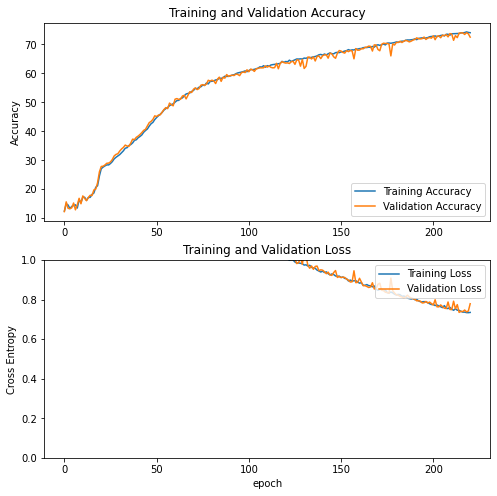

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Class accuracies using Validation Dataset**

In [20]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Tomato_Target_spot : 65 %
Accuracy of Tomato__Late_blight : 59 %
Accuracy of Tomato__Septoria_leaf_spot : 83 %
Accuracy of Tomato__Spider_mites : 59 %
Accuracy of Tomato___Bacterial_spot : 79 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 86 %
Accuracy of Tomato__early_blight : 50 %
Accuracy of Tomato__healthy : 94 %


**Class Accuracies using Test Dataset**

In [ ]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/8
print('Average accuracy = ', avg)

**Confusion Matrix using Validation Dataset:**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Tomato', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.7)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)

**Confusion Matrix using Test Dataset:**

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes,  cmap='Blues', fmt='d', cbar=False)